In [1]:
import os
from PIL import Image
from glob import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

In [ ]:
path = 'C:/Users/tkdvl/Desktop/Korean/datasets'
train_volumn = 'train-volume.tif'
train_label = 'train-labels.tif'
img = Image.open(os.path.join(path, train_volumn))
label = Image.open(os.path.join(path, train_label))

for i in range(24):
    img.seek(i)
    label.seek(i)
    img.save('./datasets/train/train_img_%03d.png' % i)
    label.save('./datasets/train/train_label_%03d.png' % i)
    
for i in range(24, 30):
    img.seek(i)
    label.seek(i)
    img.save('./datasets/valid/valid_img_%03d.png' % i)
    label.save('./datasets/valid/valid_label_%03d.png' % i)

path = 'C:/Users/tkdvl/Desktop/Korean/datasets'
test_volumn = 'test-volume.tif'
test = Image.open(os.path.join(path, test_volumn))
for i in range(30):
    test.seek(i)
    test.save('./datasets/test/test_img_%03d.png' % i)

In [2]:
img_path = sorted(glob('C:/Users/tkdvl/Desktop/Korean/datasets/train_img/*'))  
label_path = sorted(glob('C:/Users/tkdvl/Desktop/Korean/datasets/train_label/*'))
valid_path = sorted(glob('C:/Users/tkdvl/Desktop/Korean/datasets/valid_img/*'))
valid_label_path = sorted(glob('C:/Users/tkdvl/Desktop/Korean/datasets/valid_label/*'))

In [3]:
def load_train_data(img_path, label_path):
    #load image
    inputs = tf.io.read_file(img_path)
    inputs = tf.image.decode_png(inputs, channels=1)
    
    #normalization
    inputs = tf.cast(inputs, dtype=tf.float32)
    inputs = inputs / 255.
    
    #load label
    labels = tf.io.read_file(label_path)
    labels = tf.image.decode_png(labels, channels=1)
    
    #normalization
    labels = tf.cast(labels, dtype=tf.float32)
    labels = labels / 255.
    
    #augmentation
    if tf.random.uniform(()) > 0.5:
        inputs = tf.image.flip_left_right(inputs)
        labels = tf.image.flip_left_right(labels)
    
    if tf.random.uniform(()) > 0.5:
        inputs = tf.image.flip_up_down(inputs)
        labels = tf.image.flip_up_down(labels)
    
    if tf.random.uniform(()) > 0.5:   
        inputs = tf.image.rot90(inputs)
        labels = tf.image.rot90(labels)
    
    return inputs, labels

def load_valid_data(valid_path, valid_label_path):
    inputs = tf.io.read_file(valid_path)
    inputs = tf.image.decode_png(inputs, channels=1)
    inputs = tf.cast(inputs, dtype=tf.float32)
    inputs = inputs / 255.
    
    labels = tf.io.read_file(valid_label_path)
    labels = tf.image.decode_png(labels, channels=1)
    labels = tf.cast(labels, dtype=tf.float32)
    labels = labels / 255.
    
    return inputs, labels

class CustomCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, inputs, labels, model):
        super(CustomCallback, self).__init__()
        self.inputs = inputs
        self.labels = labels
        self.model = model
       
    def on_epoch_end(self, epoch, logs=None):
        img = tf.expand_dims(self.inputs, axis=0)
        preds = self.model.predict(img)
        preds = np.where(preds > 0.5, 1, 0)
        preds = preds[0]
        
        plt.figure(figsize=(15,15))
        plt.subplot(1,3,1)
        plt.title('Input')
        plt.imshow(tf.keras.preprocessing.image.array_to_img(self.inputs), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1,3,2)
        plt.title('Label')
        plt.imshow(tf.keras.preprocessing.image.array_to_img(self.labels), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1,3,3)
        plt.title('Preds')
        plt.imshow(preds, cmap='gray')
        plt.axis('off')
        plt.savefig('./unet/figure/epoch_{:03d}.jpg'.format(epoch+1))
        plt.close(fig='all')

In [4]:
train_data = tf.data.Dataset.from_tensor_slices((img_path, label_path))
train_data = train_data.map(load_train_data, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.batch(4)
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:
valid_data = tf.data.Dataset.from_tensor_slices((valid_path, valid_label_path))
valid_data = valid_data.map(load_valid_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_data.batch(4)
valid_data = valid_data.prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
for iter, batch_data in enumerate(train_data):
    if iter >= 4:
        break
    batch_image, batch_mask = batch_data[0], batch_data[1]
    inputs, labels = batch_image[0], batch_mask[0]

In [7]:
def model():
    inputs = tf.keras.layers.Input((512, 512, 1))

    #encoding part1
    conv1 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer = 'he_normal')(inputs)
    conv2 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer = 'he_normal')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D()(conv2)

    #encoding part2
    conv3 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer = 'he_normal')(pool1)
    conv4 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer = 'he_normal')(conv3)
    pool2 = tf.keras.layers.MaxPooling2D()(conv4)
    
    #encoding part3
    conv5 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer = 'he_normal')(pool2)
    conv6 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer = 'he_normal')(conv5)
    pool3 = tf.keras.layers.MaxPooling2D()(conv6)
    
    #encoding part4
    conv7 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu', kernel_initializer = 'he_normal')(pool3)
    conv8 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu', kernel_initializer = 'he_normal')(conv7)
    pool4 = tf.keras.layers.MaxPooling2D()(conv8)
    
    #encoding part5
    conv9 = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu', kernel_initializer = 'he_normal')(pool4)
    drop1 = tf.keras.layers.Dropout(0.5)(conv9)

    #decoding part5
    conv10 = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu', kernel_initializer = 'he_normal')(drop1)
    drop2 = tf.keras.layers.Dropout(0.5)(conv10)
    
    #decoding part4
    upsampling4 = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=(2, 2), strides=(2, 2), padding='same', 
                                                  kernel_initializer = 'he_normal')(drop2)
    concat4 = tf.keras.layers.Concatenate(axis=-1)([upsampling4, conv8])
    conv11 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu', kernel_initializer = 'he_normal')(concat4)
    conv12 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu', kernel_initializer = 'he_normal')(conv11)
    
    #decoding part3
    upsampling3 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(2, 2), strides=(2, 2), padding='same', 
                                                  kernel_initializer = 'he_normal')(conv12)
    concat3 = tf.keras.layers.Concatenate(axis=-1)([upsampling3, conv6])
    conv13 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer = 'he_normal')(concat3)
    conv14 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer = 'he_normal')(conv13)
    
    #decoding part2
    upsampling2 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same', 
                                                  kernel_initializer = 'he_normal')(conv14)
    concat2 = tf.keras.layers.Concatenate(axis=-1)([upsampling2, conv4])
    conv15 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer = 'he_normal')(concat2)
    conv16 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer = 'he_normal')(conv15)
    
    #decoding part1
    upsampling1 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='same', 
                                                  kernel_initializer = 'he_normal')(conv16)
    concat1 = tf.keras.layers.Concatenate(axis=-1)([upsampling1, conv2])
    conv17 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer = 'he_normal')(concat1)
    conv18 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer = 'he_normal')(conv17)
    
    fc = tf.keras.layers.Conv2D(filters=1, kernel_size=1, padding='same', activation='sigmoid')(conv18)
    
    return tf.keras.Model(inputs = inputs, outputs = fc)

In [8]:
model=model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [9]:
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, 
                                                             decay_steps=5000, 
                                                             decay_rate=0.96, 
                                                             staircase=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint("./unet/{epoch:04d}-{val_loss:0.4f}.hdf5")

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
              metrics=['accuracy'])

CustomCallback = CustomCallback(inputs, labels, model)

In [10]:
history = model.fit(train_data, 
          validation_data=valid_data, 
          epochs=200, 
          callbacks=[checkpoint, CustomCallback], 
          shuffle=True)

Epoch 1/200
6/6 [==============================] - 24s 2s/step - loss: 0.4847 - accuracy: 0.7666 - val_loss: 0.4236 - val_accuracy: 0.8035
Epoch 2/200
6/6 [==============================] - 3s 572ms/step - loss: 0.4451 - accuracy: 0.7746 - val_loss: 0.4009 - val_accuracy: 0.8035
Epoch 3/200
6/6 [==============================] - 3s 572ms/step - loss: 0.4197 - accuracy: 0.7769 - val_loss: 0.3760 - val_accuracy: 0.8050
Epoch 4/200
6/6 [==============================] - 3s 574ms/step - loss: 0.3912 - accuracy: 0.8000 - val_loss: 0.3501 - val_accuracy: 0.8184
Epoch 5/200
6/6 [==============================] - 3s 576ms/step - loss: 0.3652 - accuracy: 0.8277 - val_loss: 0.3303 - val_accuracy: 0.8388
Epoch 6/200
6/6 [==============================] - 3s 575ms/step - loss: 0.3508 - accuracy: 0.8366 - val_loss: 0.3252 - val_accuracy: 0.8481
Epoch 7/200
6/6 [==============================] - 3s 573ms/step - loss: 0.3523 - accuracy: 0.8330 - val_loss: 0.2948 - val_accuracy: 0.8694
Epoch 8/200
6/6

Epoch 57/200
6/6 [==============================] - 3s 591ms/step - loss: 0.2070 - accuracy: 0.9095 - val_loss: 0.2043 - val_accuracy: 0.9163
Epoch 58/200
6/6 [==============================] - 4s 614ms/step - loss: 0.2066 - accuracy: 0.9099 - val_loss: 0.2071 - val_accuracy: 0.9172
Epoch 59/200
6/6 [==============================] - 3s 585ms/step - loss: 0.2045 - accuracy: 0.9114 - val_loss: 0.1972 - val_accuracy: 0.9200
Epoch 60/200
6/6 [==============================] - 3s 597ms/step - loss: 0.2020 - accuracy: 0.9126 - val_loss: 0.2047 - val_accuracy: 0.9165
Epoch 61/200
6/6 [==============================] - 3s 584ms/step - loss: 0.1971 - accuracy: 0.9141 - val_loss: 0.2079 - val_accuracy: 0.9175
Epoch 62/200
6/6 [==============================] - 3s 572ms/step - loss: 0.1960 - accuracy: 0.9143 - val_loss: 0.1931 - val_accuracy: 0.9201
Epoch 63/200
6/6 [==============================] - 3s 581ms/step - loss: 0.1954 - accuracy: 0.9149 - val_loss: 0.2123 - val_accuracy: 0.9145
Epoch 

6/6 [==============================] - 4s 643ms/step - loss: 0.1670 - accuracy: 0.9268 - val_loss: 0.1930 - val_accuracy: 0.9233
Epoch 115/200
6/6 [==============================] - 4s 623ms/step - loss: 0.1711 - accuracy: 0.9253 - val_loss: 0.1939 - val_accuracy: 0.9198
Epoch 116/200
6/6 [==============================] - 3s 585ms/step - loss: 0.1758 - accuracy: 0.9227 - val_loss: 0.2223 - val_accuracy: 0.9182
Epoch 117/200
6/6 [==============================] - 3s 611ms/step - loss: 0.1781 - accuracy: 0.9228 - val_loss: 0.1975 - val_accuracy: 0.9201
Epoch 118/200
6/6 [==============================] - 3s 588ms/step - loss: 0.1701 - accuracy: 0.9254 - val_loss: 0.1984 - val_accuracy: 0.9245
Epoch 119/200
6/6 [==============================] - 3s 588ms/step - loss: 0.1730 - accuracy: 0.9239 - val_loss: 0.2058 - val_accuracy: 0.9204
Epoch 120/200
6/6 [==============================] - 3s 593ms/step - loss: 0.1682 - accuracy: 0.9262 - val_loss: 0.2076 - val_accuracy: 0.9234
Epoch 121/200

6/6 [==============================] - 3s 588ms/step - loss: 0.1536 - accuracy: 0.9325 - val_loss: 0.2206 - val_accuracy: 0.9210
Epoch 172/200
6/6 [==============================] - 3s 589ms/step - loss: 0.1482 - accuracy: 0.9349 - val_loss: 0.2266 - val_accuracy: 0.9241
Epoch 173/200
6/6 [==============================] - 4s 623ms/step - loss: 0.1516 - accuracy: 0.9332 - val_loss: 0.2271 - val_accuracy: 0.9221
Epoch 174/200
6/6 [==============================] - 3s 589ms/step - loss: 0.1504 - accuracy: 0.9338 - val_loss: 0.2285 - val_accuracy: 0.9234
Epoch 175/200
6/6 [==============================] - 4s 615ms/step - loss: 0.1523 - accuracy: 0.9329 - val_loss: 0.2203 - val_accuracy: 0.9150
Epoch 176/200
6/6 [==============================] - 3s 584ms/step - loss: 0.1544 - accuracy: 0.9317 - val_loss: 0.2140 - val_accuracy: 0.9218
Epoch 177/200
6/6 [==============================] - 3s 583ms/step - loss: 0.1545 - accuracy: 0.9320 - val_loss: 0.2113 - val_accuracy: 0.9242
Epoch 178/200

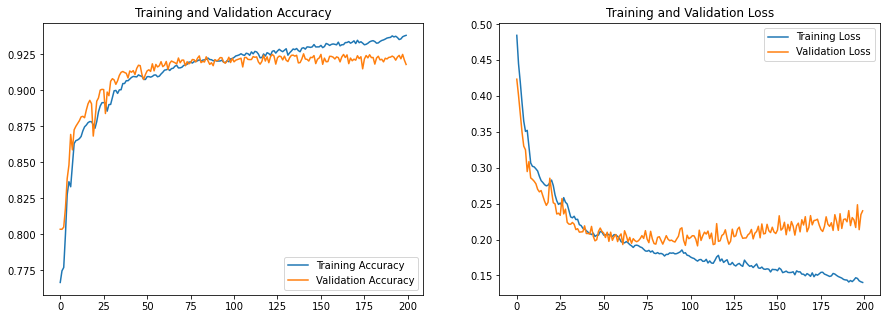

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

fig = plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()